In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [2]:
df = pd.read_json("pycharm_issues.json", lines=True)

In [3]:
interesting_versions = ["2020.2", "2020.3", "2021.1", "2021.2", "2021.3"]

def check(versions):
    for x in interesting_versions:
        if x in versions:
            return True
    return False

df = df[df["Affected versions"].apply(check)].reset_index()

In [4]:
counter = CountVectorizer(
    ngram_range=(2, 3), 
    max_df=0.2
)
X = counter.fit_transform(df["summary"])

In [5]:
n_topics = 7
lda = LDA(n_components=n_topics, random_state=339264239)
lda.fit(X)

LatentDirichletAllocation(n_components=7, random_state=339264239)

In [6]:
affected_2020_2 = X[df[df["Affected versions"].apply(lambda x: "2020.2" in x)].index, :]
affected_2020_3 = X[df[df["Affected versions"].apply(lambda x: "2020.3" in x)].index, :]

In [7]:
meaningless_words=['is not', 'are not', 'does not', 'in pycharm', 'py charm', 'of the', 'in the', 'instead of', 
    'is used', 'number of', 'not work', 'does not work', 'unable to', 'in python', 'not working', 'work on', 
    'python 10', 'fails to', 'error when', 'way to', 'to the', 'doesn work', 'if the', 'pycharm 2020', 'pycharm 2021', 'no longer',
    'when using', 'not be', 'from the', 'must not be', 'pycharm does', 'pycharm does not',
    'can be', 'must not']

feature_names = counter.get_feature_names_out()[np.argsort(lda.components_, axis=-1)[:, ::-1]]
docs = lda.transform(X)

for features, confidence, doc in zip(feature_names, docs.max(axis=0), df["summary"][docs.argmax(axis=0)]):
    out_features = [x for x in features if x not in meaningless_words][:5]
    print(confidence, doc)
    print(out_features)
    print()

0.9902584576665416 When I move my project in other directory and even delete .idea  PyCharm have troubles with identifying the way to my venv interpreter. It changing this path as soon as I configure it in previous window.  (I`m creatining venv through 'python -m venv venv'). I faced with this problem before.
['false positive', 'python console', 'type inference', 'in python console', 'incorrect type']

0.9841137212990364 IDE keeps disabling Python plugin, I get and error "Unable to save plugin settings: The plugin Pythonid failed to save settings and has been disabled. Please restart IntelliJ IDEA"
['python console', 'false positive', 'jupyter notebook', 'on windows', 'type hint']

0.982847093786736 Wrong type evaluation in if-else block and different attribute hints for if-else block and inline if-else when some exception can be raised before
['completion for', 'code completion', 'no completion for', 'no completion', 'on windows']

0.9821375586559549 I run PyCharm Community inside or 

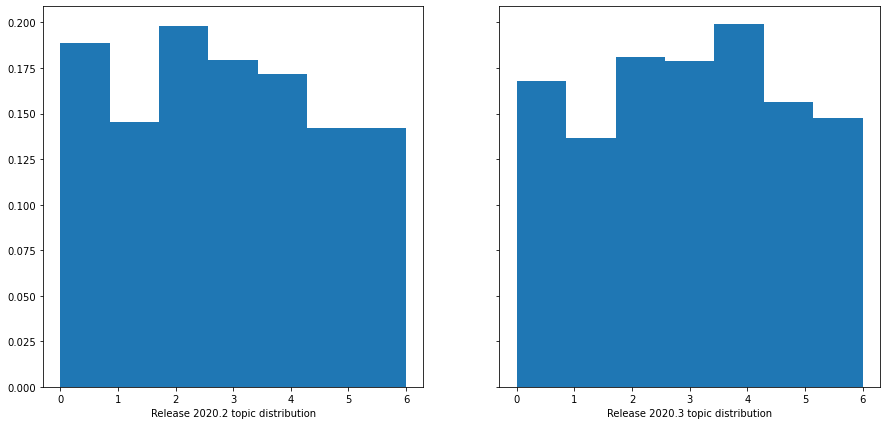

In [8]:
topics_2020_2 = lda.transform(affected_2020_2).argmax(axis=-1)
topics_2020_3 = lda.transform(affected_2020_3).argmax(axis=-1)

fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(7)

axs[0].hist(topics_2020_2, bins=n_topics, density=True)
axs[0].set_xlabel("Release 2020.2 topic distribution")

axs[1].hist(topics_2020_3, bins=n_topics, density=True)
axs[1].set_xlabel("Release 2020.3 topic distribution")

plt.show()

# Модель

Была построена тематическая модель на основе sklearn.LatentDirichletAllocation (Латентное размещение Дирихле) для тикетов, связанных с релизами с 2020.2 по 2021.3 по сочетаниям из 2-3 слов из summary тикетов

# Темы

Для интерпретации полученных тем для каждой модели был взят наиболее вероятный документ, это документ с наибольшей вероятностью того, что документ имеет данную тему $P(d|t) = \frac{P(t|d) P(d)}{P(t)} \sim P(t|d)$, так как априорная вероятность всех документов одинаковая

Также для каждой темы были взяты 5 наиболее вероятных словосочетаний, исключая те, которые бесполезны для определения темы (список meaningless_words)

В итоге получилось выделить следующие 7 тем:
* Тема 1: проблема с venv
* Тема 2: ошибка плагина
* Тема 3: ошибка приведения типов
* Тема 4: ошибка сохранения настроек
* Тема 5: проблема с производительностью
* Тема 6: проблема с пошаговой отладкой
* Тема 7: ошибка с зависимостями

# Визуализация

Были построены гистограммы для релизов 2020.2 и 2020.3 с распределением тикетов по темам, по которым можно сделать следующий вывод:
* В релизе 2020.2 больше всего проблем было связано с приведением типов
* В релизе 2020.3 по сравнению с релизом 2020.2 таких ошибок стало меньше в процентном соотношении, зато появилось больше жалоб на производительность

# Проблемы модели

В действительности, интерпретация тем довольно неточная, что можно наблюдать даже по тому, как summary топовых тикетов соотносится с наиболее частыми словосочетаниями. Скорее всего на это могло повлиять недостаточное количество данных для построения модели, а также то, что некоторые тикеты (что видно выше) ссылаются на проблемы при переходе между релизами, а следовательно, от релиза к релизу проблемы пользователей несколько меняются, и строя единую модель для них всех, теряется часть информации специфичная для конкретных релизов.